# Here is an example for PINN-based tomography

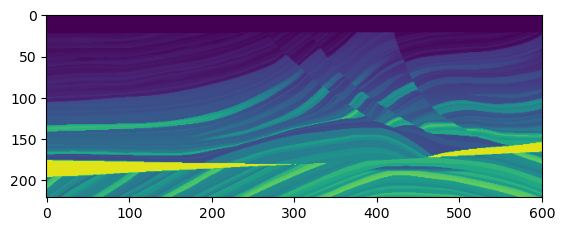

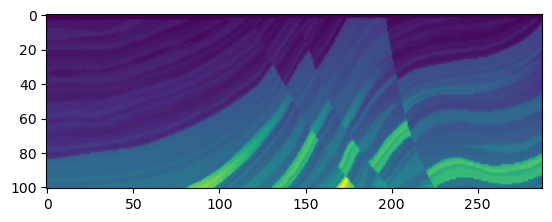

In [1]:
#conda activate eqp (eqpolarity or eqpicking environment)
# to be changed
# Mac Pro Base Env
#
# Or
# python 3.12.7
# pykonal: 0.4.1
# scikit-learn: 1.5.1
# scipy: 1.13.1
# torch: 2.6.0
# torchvision: 0.21.0

import os
import numpy as np 
from scipy import interpolate
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

# import library
def numerical_traveltime2d(vel, nx, nz, ns, xmin, zmin, deltax, deltaz, id_sou_x, id_sou_z):
    
    import pykonal

    T_data_surf = np.zeros((nz,nx,ns))

    for i in range(ns):

        solver = pykonal.EikonalSolver(coord_sys="cartesian")
        solver.velocity.min_coords = zmin, xmin, zmin
        solver.velocity.node_intervals = deltaz, deltax, deltaz
        solver.velocity.npts = nz, nx, 1
        solver.velocity.values = vel.reshape(nz,nx,1)

        src_idx = id_sou_z[i], id_sou_x[i], 0
        
        solver.traveltime.values[src_idx] = 0
        solver.unknown[src_idx] = False
        solver.trial.push(*src_idx)

        solver.solve()

        teik = solver.traveltime.values

        T_data_surf[:,:,i] = teik[:,:,0]
        
    return T_data_surf


zmin = 0; zmax = 1; deltaz = 0.01;
xmin = 0.; xmax = 8.6; deltax = 0.03;

z = np.arange(zmin,zmax+deltaz,deltaz)
nz = z.size

x = np.arange(xmin,xmax+deltax,deltax)
nx = x.size

vel = np.fromfile('smalldata/marmousi.bin', np.float32).reshape(221, 601)
plt.imshow(vel);plt.show()

x1 = np.linspace(0, 5, 601)
z1 = np.linspace(0, 1, 221) 
x2 = np.linspace(0.25, 5, len(x))
z2 = np.linspace(0.09, 0.55, len(z)) 
f = interpolate.interp2d (x1, z1, vel)
vel = f(x2, z2)

plt.imshow(vel);plt.show()

In [2]:
id_sou_x=np.array([  0,  40,  80, 120, 160, 200, 240, 280]);
id_sou_z=np.array([5, 5, 5, 5, 5, 5, 5, 5]);

id_rec_x=np.array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280])
id_rec_z=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

T_data = numerical_traveltime2d(vel, len(x), len(z), len(id_sou_x), xmin, zmin, deltax, deltaz, id_sou_x, id_sou_z)

T_data.shape


(101, 288, 8)

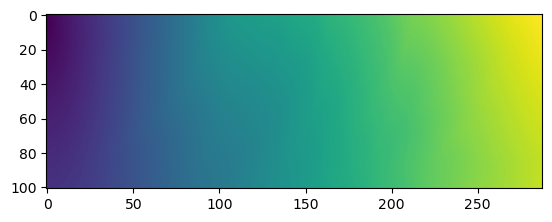

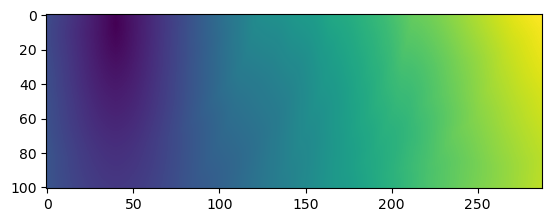

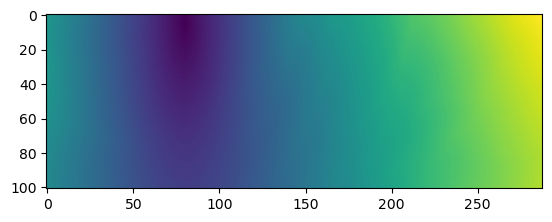

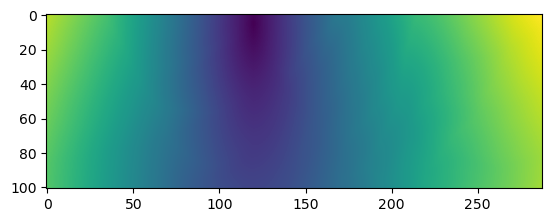

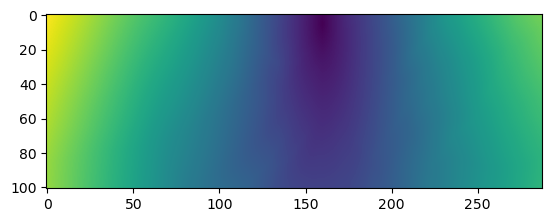

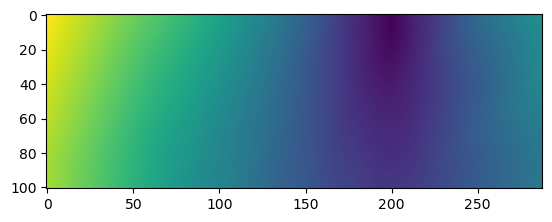

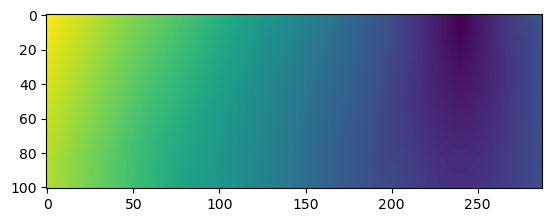

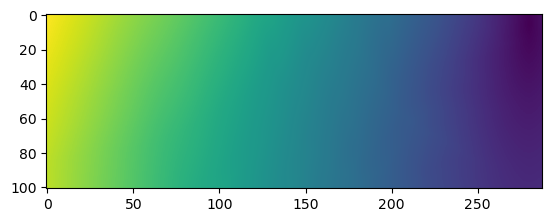

In [3]:
for ii in range(T_data.shape[2]):
    plt.imshow(T_data[:,:,ii])
    plt.show()

In [4]:
import torch

Td_nn = np.zeros_like(T_data)
taudx_nn = np.zeros_like(T_data)

Ti_data = np.zeros((len(x[id_rec_x])*len(id_sou_x)))
xri = np.tile(x[id_rec_x], len(id_sou_x))
zri = np.tile(z[id_rec_z], len(id_sou_z))
xsi = np.repeat(x[id_sou_x], len(id_rec_x))
zsi = np.repeat(z[id_sou_z], len(id_rec_z))

for i in range(len(id_sou_x)):
    Ti_data[i*len(x[id_rec_x]):(i+1)*len(x[id_rec_x])] = T_data[id_rec_z,id_rec_x,i]

rand_idx = np.random.permutation(np.arange(len(Ti_data)))

X_ori = np.vstack((xri, zri, xsi, zsi)).T
y_ori = Ti_data

X_all = X_ori[rand_idx,:]
y_all = y_ori[rand_idx]

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

X_ori = torch.from_numpy(X_ori).float()

all_dataset = torch.utils.data.TensorDataset(X_all, y_all)

# Use Pytorch's functionality to load data in batches. Here we use full-batch training again.
all_loader = torch.utils.data.DataLoader(all_dataset, batch_size=16, shuffle=True)


In [5]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch.nn import Linear

def activation(act_fun='leakyrelu'):

    if isinstance(act_fun, str):
        if act_fun == 'leakyrelu':
            return nn.LeakyReLU(0.2, inplace='y')
        elif act_fun == 'elu':
            return nn.ELU()
        elif act_fun == 'relu':
            return nn.ReLU()
        elif act_fun == 'tanh':
            return nn.Tanh()
        elif act_fun == 'swish':
            return Swish()
        else:
            raise ValueError(f'{act_fun} is not an activation function...')
    else:
        return act_fun

def layer(lay='linear'):
    if isinstance(lay, str):
        if lay == 'linear':
            return lambda x,y: nn.Linear(x, y)
        
        elif lay == 'adaptive':
            return lambda x,y: AdaptiveLinear(x,y,
                                              adaptive_rate=0.1,
                                              adaptive_rate_scaler=10.)
        else:
            raise ValueError(f'{lay} is not a layer type...')
    else:
        return lay

class ResidualNetwork(torch.nn.Module):
    def __init__(self, num_input, num_output, num_layers=10, num_neurons=10,
                 lay='linear', act='relu', last_act=None, last_multiplier=1, last_abs=False):
        
            super(ResidualNetwork, self).__init__()
            
            self.act = activation(act)
            self.last_act = activation(last_act)
            self.last_multiplier = last_multiplier
            self.last_abs = last_abs

            # Input Structure
            self.fc0  = Linear(num_input,num_neurons)
            self.fc1  = Linear(num_neurons,num_neurons)

            # Resnet Block
            self.rn_fc1 = torch.nn.ModuleList([Linear(num_neurons, num_neurons) for i in range(num_layers)])
            self.rn_fc2 = torch.nn.ModuleList([Linear(num_neurons, num_neurons) for i in range(num_layers)])
            self.rn_fc3 = torch.nn.ModuleList([Linear(num_neurons, num_neurons) for i in range(num_layers)])

            # Output structure
            self.fc8  = Linear(num_neurons,num_neurons)
            self.fc9  = Linear(num_neurons,num_output)

    def forward(self,x):
        x = self.act(self.fc0(x))
        x = self.act(self.fc1(x))
        for j in range(len(self.rn_fc1)):
            x0 = x
            x  = self.act(self.rn_fc1[j](x))
            x  = self.act(self.rn_fc3[j](x)+self.rn_fc2[j](x0))

        x = self.act(self.fc8(x))
        x = self.fc9(x)
        
        if self.last_act is not None:
            x = self.last_act(x)
        elif self.last_abs:
            x = torch.abs(x)
        x = x * self.last_multiplier
        return x

class FullyConnectedNetwork(nn.Module):
    
    def __init__(self, num_input, num_output, n_hidden=[16, 32],
                 lay='linear', act='tanh', last_act=None, last_multiplier=1):
        super(FullyConnectedNetwork, self).__init__()
        self.lay = lay
        self.act = act
        self.last_multiplier = last_multiplier
        self.last_act = last_act

        act = activation(act)
        lay = layer(lay)
        if last_act == 'sigmoid':
            self.model = nn.Sequential(
                nn.Sequential(lay(num_input, n_hidden[0]), act),
                *[nn.Sequential(lay(n_hidden[i], n_hidden[i + 1]),act) for i in range(len(n_hidden) - 1)],
                lay(n_hidden[-1], num_output),
                nn.Sigmoid()
            )
        elif last_act == 'relu':
            self.model = nn.Sequential(
                nn.Sequential(lay(num_input, n_hidden[0]), act),
                *[nn.Sequential(lay(n_hidden[i], n_hidden[i + 1]),act) for i in range(len(n_hidden) - 1)],
                lay(n_hidden[-1], num_output),
                nn.ReLU()
            )
        elif last_act == 'tanh':
            self.model = nn.Sequential(
                nn.Sequential(lay(num_input, n_hidden[0]), act),
                *[nn.Sequential(lay(n_hidden[i], n_hidden[i + 1]),act) for i in range(len(n_hidden) - 1)],
                lay(n_hidden[-1], num_output),
                nn.Tanh()
            )
        else:
            self.model = nn.Sequential(
                nn.Sequential(lay(num_input, n_hidden[0]), act),
                *[nn.Sequential(lay(n_hidden[i], n_hidden[i + 1]),act) for i in range(len(n_hidden) - 1)],
                lay(n_hidden[-1], num_output)
            )

    def forward(self, x):
        x = self.model(x) #/ (1-0.9999)
        return x*self.last_multiplier
    
class VelocityNetwork(torch.nn.Module):
    def __init__(self, base_model, v_well=1, X_well=None):
        
            super(VelocityNetwork, self).__init__()
            
            self.model = base_model
            self.v_well = v_well
            self.X_well = X_well
            
            if self.X_well is not None:
                self.x_well = X_well[:,0]
                self.y_well = X_well[:,1]
            
    def _well_operator(self, x):
#         x_op, y_op = 1, 1
        
#         for i in range(len(self.x_well)):
#             x_op *= (x[:,0] - self.x_well[i]) 
#         for i in range(len(self.y_well)):
#             y_op *= (x[:,1] - self.y_well[i])
        
#         return nn.Tanh()(x_op + y_op)

        return torch.exp(-0.05*x[:,2]).view(-1,1)

    def forward(self,x,v_well=1):
        
        if self.X_well is not None:
            x = v_well.view(-1,1) + self.model(x) #* self._well_operator(x)
        else:
            x = self.model(x)
        return x
    
import pytorch_lightning as pl
import torchvision
import torch.nn.functional as F

from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)

class Encoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 128 => 64
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 64 => 32
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 32 => 16
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16 => 4
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16 => 4
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            # nn.Linear(2*16**2*c_hid, latent_dim)
            nn.Linear(2*4**2*c_hid, latent_dim)
        )
    
    def forward(self, x):
        return self.net(x)
    
class Decoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            # nn.Linear(latent_dim, 2*16**2*c_hid),
            nn.Linear(latent_dim, 2*4**2*c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4 => 8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8 => 16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 16 => 32
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 32 => 64
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 64 => 128
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x
    
class AutoEncoder(pl.LightningModule):
    
    def __init__(self, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3, 
                 width: int = 128, 
                 height: int = 128):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters() 
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)
        
    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
    def _get_reconstruction_loss(self, batch):
        """
        Given a batch of images, this function returns the reconstruction loss (MSE in our case)
        """
        x, _ = batch # We do not need the labels
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                         mode='min', 
                                                         factor=0.2, 
                                                         patience=20, 
                                                         min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
    
    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)                             
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss)
    
    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)
        
    def encode(self, x):
        """
        The forward function takes in an image and returns the latent variables
        """
        z = self.encoder(x)
        # x_hat = self.decoder(z)
        return z
    
    def encode(self, z):
        """
        The forward function takes in a latent variables and returns the reconstructed image
        """
        x_hat = self.decoder(z)
        return x_hat
    
class GenerateCallback(pl.Callback):
    
    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs # Images to reconstruct during training
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)
        
    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()
            # Plot and add to tensorboard
            imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
            grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, range=(-1,1))
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step=trainer.global_step)

Epoch: 50, Loss: 0.0011801253771409393
Epoch: 100, Loss: 0.0005819935099376987
Epoch: 150, Loss: 0.00045535072567872705
Epoch: 200, Loss: 0.00014215236878953875
Epoch: 250, Loss: 0.00018405523636223127
Epoch: 300, Loss: 0.00011089504065845783
Epoch: 350, Loss: 0.0001724347782631715
Epoch: 400, Loss: 0.0001335181111547475
Epoch: 450, Loss: 0.00011103119468316435
Epoch: 500, Loss: 0.0001038236788493426
Epoch: 550, Loss: 0.00045468557121542595
Epoch: 600, Loss: 0.00012873548839706928
Epoch: 650, Loss: 0.00017419098197327305
Epoch: 700, Loss: 9.537601484529053e-05
Epoch: 750, Loss: 9.674331498293517e-05
Epoch: 800, Loss: 7.171760807977989e-05
Epoch: 850, Loss: 0.00016604977330037703
Epoch: 900, Loss: 5.805784603580832e-05
Epoch: 950, Loss: 4.455076753705119e-05


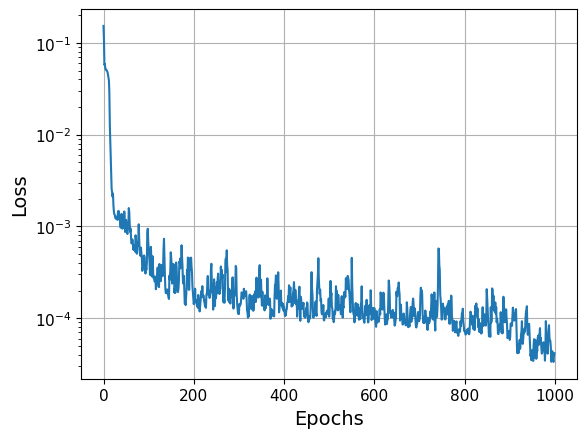

In [6]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

reduce_after=50
data_layers=8
data_neurons=16
zid_receiver=0
field_synthetic='n'
sx=np.array([0. , 1.2, 2.4, 3.6, 4.8, 6. , 7.2, 8.4])
sz=np.array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])
if 1:
    torch.manual_seed(8888)
    model = FullyConnectedNetwork(4, 1, n_hidden=[data_neurons]*data_layers, act='elu')
    # optimizer = torch.optim.Adam(model.parameters(), lr=5e-4) # best
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=int(5*args.reduce_after), verbose=True)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=int(4*reduce_after), verbose=True)
    criterion = torch.nn.MSELoss()
    model.train()
    loss_data = []
    for epoch in range(int(1e3)):
        total_loss = 0.
        model.train()
        loss = 0
        for x_i, y_i in all_loader:
            optimizer.zero_grad()
            yest = model(x_i).view(-1)
            loss = criterion(yest, y_i)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 50 == 0 and epoch > 0:
            print(f'Epoch: {epoch}, Loss: {total_loss / X_all[:,0].detach().numpy().size}')
        mean_loss = total_loss / X_all[:,0].detach().numpy().size
        # wandb.log({"data_loss": mean_loss})
        scheduler.step(mean_loss)
        loss_data.append(mean_loss)

    Td_nn = np.zeros_like(T_data)
    
    if field_synthetic=='y':
        X_all = [np.tile(x[id_top_x], len(sx)), np.tile(z[id_top_z], len(sz)), 
                 np.repeat(x[id_sou_x], len(x[id_top_x])), 
                 np.repeat(z[id_sou_z], len(z[id_top_z]))]
    else:
        X_all = [np.tile(x, len(sx)), np.tile(z[zid_receiver]*np.ones_like(x), len(sz)), 
                 np.repeat(x[id_sou_x], len(x)), 
                 np.repeat(z[id_sou_z], len(x))]

    model.eval()
    Td_pred = model(torch.FloatTensor(X_all).T)

    for i in range(len(id_sou_x)):
        Td_nn[:,:,i] = Td_pred[i*len(x):(i+1)*len(x)].detach().numpy().reshape(-1)

    # Convergence history plot for verification
    fig = plt.figure()
    ax = plt.axes()
    ax.semilogy(loss_data)

    ax.set_xlabel('Epochs',fontsize=14)

    plt.xticks(fontsize=11)

    ax.set_ylabel('Loss',fontsize=14)
    plt.yticks(fontsize=11);
    plt.grid()
    plt.savefig(os.path.join('./', "data_loss.png"), format='png', bbox_inches="tight")

    # Save model
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_data
    }, './data.h5')

